In [98]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [99]:
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.model import stepmodel
import os
import pandas as pd
if manual:
    %matplotlib inline

In [100]:
training_folder = '../../'

In [101]:
sm = stepmodel.read_zippedpickles(training_folder + r'model/{scen}/walk_model'.format(scen=scenario))

zone_to_transit: 100%|█████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 27.72it/s]


# ADD SPEED ON LINKS
average speed on road_links

In [103]:
bus = sm.links.loc[sm.links['route_type'] == 'bus']
bus_lines = bus.groupby('route_id')[['time', 'road_length']].sum()
bus_speed = bus['road_length'].sum() / bus['time'].sum() # operation speed
print('bus_speed =', bus_speed, 'm / s')

bus_speed = 4.97642462585034 m / s


In [104]:
#cellule bizarre
# pt
sm.links['headway'] = 300
sm.links['length'] = sm.links['road_length']

# road
car_speed = bus_speed * 1.25
sm.road_links['time'] = sm.road_links['length'] / car_speed # m/s

# walk
sm.road_links['walk_time'] = sm.road_links['time'] * 3 # walk three times slower than car

# PT PATHFINDER
## walk on road
people walk on the road network, slow computation

In [105]:
wor = sm.copy()
wor.step_pt_pathfinder(broken_modes=False, broken_routes=False, walk_on_road=True)

path_analysis: 100%|██████████████████████████████████████████████████████████| 12100/12100 [00:00<00:00, 53118.07it/s]


## as the crow flies
people walk on dedicated access and egress links only

In [106]:
acf = sm.copy()
acf.step_pt_pathfinder(broken_modes=False, broken_routes=False)

path_analysis: 100%|██████████████████████████████████████████████████████████| 12100/12100 [00:00<00:00, 75579.12it/s]


In [107]:
# here we chose to use the ACF paths
sm.pt_los = acf.pt_los

# ROAD PATHFINDER

In [108]:
#sm.step_road_pathfinder(method = 'aon')

In [109]:
sm.step_road_pathfinder(method = 'aon')

self.volumes does not exist. od generated with self.zones


In [110]:
sm.car_los.drop(columns=["gtime"],inplace = True)

In [111]:
if not os.path.isdir(training_folder + 'model/{scen}'.format(scen=scenario)):
    os.mkdir(training_folder + "model/%s" % scenario)
sm.to_zippedpickles(training_folder + 'model/{scen}/aon_pathfinder'.format(scen=scenario))  

car_los: 100%|█████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 12.05it/s]


# PLOT

<AxesSubplot:xlabel='gtime', ylabel='time'>

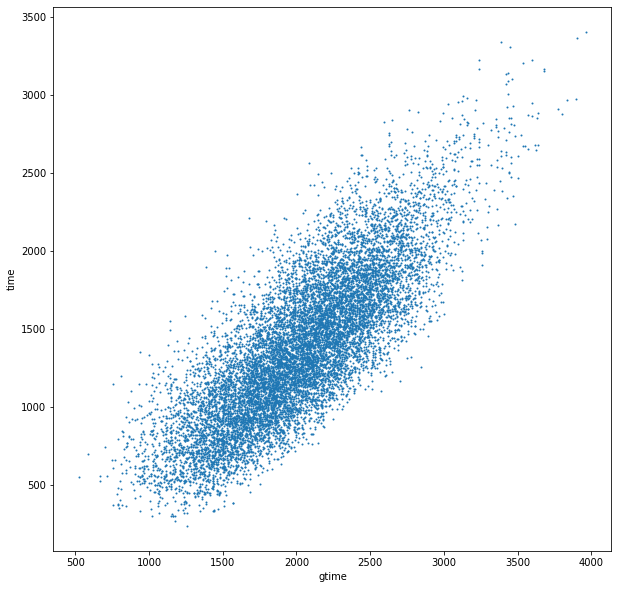

In [70]:
los = pd.merge(sm.pt_los, sm.car_los, on=['origin', 'destination'])
los = los.loc[los['origin'] != los['destination']]
los.plot(kind='scatter', x='gtime', y='time', figsize=[10, 10], s=1)

# END